In [1]:
```
Simulate an unsteady PSR with oscilation
```
using Arrhenius
using LinearAlgebra
using DifferentialEquations
using ForwardDiff
using DiffEqSensitivity
using Sundials
using Plots
using DelimitedFiles
using Flux
using Flux.Optimise: update!
using Flux.Losses: mae

## 1. Validation

In [2]:
# Load cantera data for comparision
cantera_data = readdlm("cantera/data_T.txt");
ct_t = cantera_data[:, 1];
ct_T = cantera_data[:, 2];
ct_Y = cantera_data[:, 3:end];
ct_u = hcat(ct_Y, ct_T)';

# Arrhenius.jl
gas = CreateSolution("./cantera/CH4_Kazakov_s22r104.yaml");
ns = gas.n_species;

# Load inlet conditions
# 300, P, 'H2:9.5023,CO:1.7104,CH4:5.7014,O2:17.0090,N2:66.0769'
TYin = readdlm("cantera/TYin.txt")
Yin = zeros(ns)
Tin = 300.0

for (i, s) in enumerate(["H2", "CO", "CH4", "O2", "N2"])
    Yin[species_index(gas, s)] = TYin[i+1]
end

P = one_atm
Y0 = ct_Y[1, :]
T0 = ct_T[1]
u0 = vcat(Y0, T0);

$$
\begin{align}
\frac{d \boldsymbol{Y}}{dt} &= \frac{\boldsymbol{Y_{in}}-\boldsymbol{Y}}{\tau_{res}} + \boldsymbol{S} \\
\frac{d T}{dt} &= \frac{\sum_i q_i R_i}{\rho C_p} - \frac{T-T_{in}}{\tau_res} - \frac{Q_{loss}(T-T_a)}{\rho C_p} \\
\tau_{res} &= \frac{\rho V}{m_a}
\end{align}
$$


In [3]:
@inbounds function dudt!(du, u, p, t)
    Tin = p[1]  # 300.0
    Ta = p[2]  # 760.0
    Q = p[3] # 8.e2
    tres = p[4] # 1.0
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1.0 / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = @. wdot / ρ_mass * gas.MW + (Yin - Y) / tres
    Tdot =
        -dot(h_mole, wdot) / ρ_mass / cp_mass +
        (Tin - T) / tres +
        Q * (Ta - T) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end

dudt! (generic function with 1 method)

In [4]:
reltol=1e-9
abstol=1e-12

tspan = [0.0, ct_t[end]*1.001];
p = [300.0, 760.0, 8.e2, 1.0];
prob = ODEProblem(dudt!, u0, tspan, p);
sol = solve(prob, TRBDF2(), reltol=reltol, abstol=abstol, saveat=ct_t);
ar_u = Array(sol);

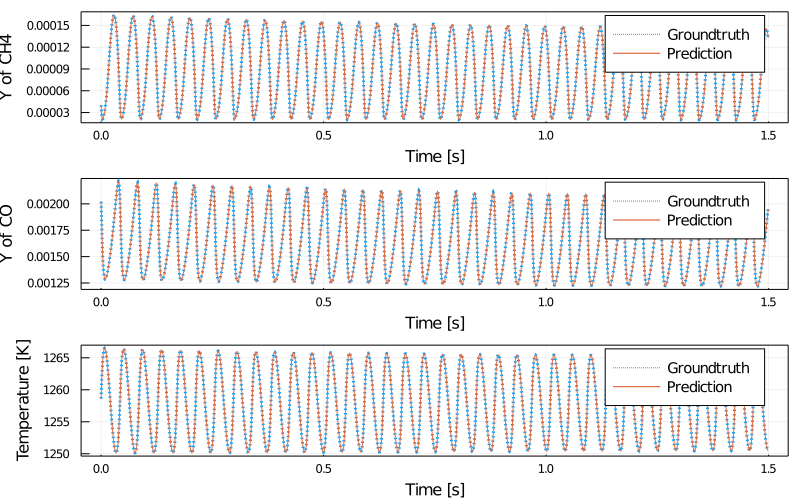

In [5]:
fs = 10;

function valid(t, y_true, y_pred)
    IJulia.clear_output(true)
    
    h1 = plot(legend=true, legendfontsize=fs)#, foreground_color_legend=nothing)
    plot!(t, y_true[species_index(gas, "CH4"),:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[species_index(gas, "CH4"),:], line=(1,:solid), label="Prediction")
    ylabel!(h1, "Y of CH4")
    xlabel!(h1, "Time [s]")

    h2 = plot(legend=true, legendfontsize=fs)#, foreground_color_legend=nothing)
    plot!(t, y_true[species_index(gas, "CO"),:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[species_index(gas, "CO"),:], line=(1,:solid), label="Prediction")
    ylabel!(h2, "Y of CO")
    xlabel!(h2, "Time [s]")
    
    h3 = plot(legend=true, legendfontsize=fs)#, foreground_color_legend=nothing)
    plot!(t, y_true[end,:], line=(3,:dot), label="Groundtruth")
    plot!(t, y_pred[end,:], line=(1,:solid), label="Prediction")
    ylabel!(h3, "Temperature [K]")
    xlabel!(h3, "Time [s]")
    
    h = plot(h1, h2, h3,
        layout=(3,1), size=(800,500), framestyle=:box)
    display(h)
    sleep(1e-9)
end

valid(ct_t, ct_u, ar_u)

## 2. Optimize

In [6]:
using Arrhenius
using ForwardDiff
using LinearAlgebra
using DiffEqSensitivity
using DifferentialEquations

using Random
using ProgressBars
using DelimitedFiles
using Plots, Colors, Printf, Profile

In [7]:
# settings
solver = TRBDF2();
reltol = 1e-9
abstol = 1e-12
sensealg = ForwardDiffSensitivity()

datasize = 100;
tsteps = range(0, 0.2, length=datasize);
tspan = [0.0, tsteps[end]*1.001];

In [8]:
p0 = [300.0, 760.0, 8.e2, 1.0];

### 2.1 Test for gradient computation

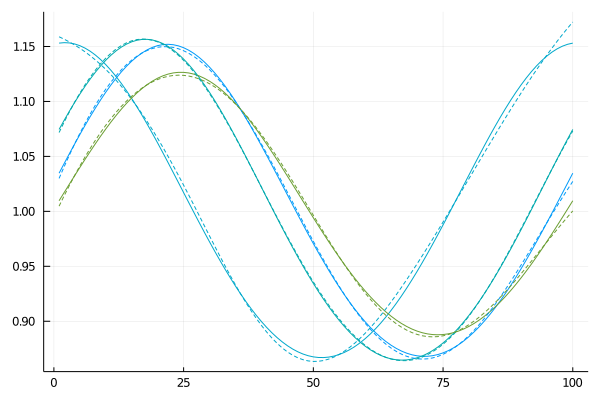

In [79]:
tscale = tsteps[end] / (2*pi);

# network structure
nn_inlet = Chain(x -> x,
                Dense(1, 5, tanh),
                Dense(5, 4, exp))

# generate random data series
rng = MersenneTwister(0x777777);
Φ = rand(rng, 4)*pi; # random phases
K = exp.(rand(rng, 4)/2);
f = x -> exp.(sin.(x .+ Φ)/10 .* K);
pk_true = hcat([f(t) for t in (tsteps./tscale)]...)

# Fit for true parameters
ps = Flux.params(nn_inlet)
loss() = Flux.mse(nn_inlet((tsteps./tscale)'), pk_true)
opt = ADAMW(0.1, (0.9, 0.999), 1.f-6);
data = Iterators.repeated((), 10000)
Flux.train!(loss, ps, data, opt)

p_true, re = Flux.destructure(nn_inlet);

# show true time series
plot(palette=palette(:default, 4))
plot!(pk_true', line=:solid, label="")
plot!(re(p_true)((tsteps./tscale)')', line=:dash, label="")

In [83]:
p_init = exp.(0.1*(2*rand(rng, length(p_true)).-1)) .* p_true;

# If we have multiple Neural Network, we can concat them
@inbounds function nndudt!(du, u, p, t)
    inlet = p0 .* re(p)([t]./tscale);
    local Tin = inlet[1];
    local Ta = inlet[2];
    local Q = inlet[3];
    local tres = inlet[4];
    T = u[end]
    Y = @view(u[1:ns])
    mean_MW = 1.0 / dot(Y, 1 ./ gas.MW)
    ρ_mass = P / R / T * mean_MW
    X = Y2X(gas, Y, mean_MW)
    C = Y2C(gas, Y, ρ_mass)
    cp_mole, cp_mass = get_cp(gas, T, X, mean_MW)
    h_mole = get_H(gas, T, Y, X)
    S0 = get_S(gas, T, P, X)
    wdot = wdot_func(gas.reaction, T, C, S0, h_mole)
    Ydot = @. wdot / ρ_mass * gas.MW + (Yin - Y) / tres
    Tdot =
        -dot(h_mole, wdot) / ρ_mass / cp_mass +
        (Tin - T) / tres +
        Q * (Ta - T) / ρ_mass / cp_mass
    du .= vcat(Ydot, Tdot)
end
probnn = ODEProblem(nndudt!, u0, tspan, p);

In [84]:
# # Compute the gradient of state variable to PSR parameters
# sensealg = ForwardDiffSensitivity()
# function fsol(p)
#     sol = solve(probnn, p=p, solver, saveat=tsteps,
#         reltol=reltol, abstol=abstol, sensealg=sensealg);
#     return sol[end, end]
# end
# println("timing ode solver ...")
# @time fsol(p_pred)
# @time fsol(p_pred)
# @time ForwardDiff.gradient(fsol, p_pred)
# @time ForwardDiff.gradient(fsol, p_pred)'

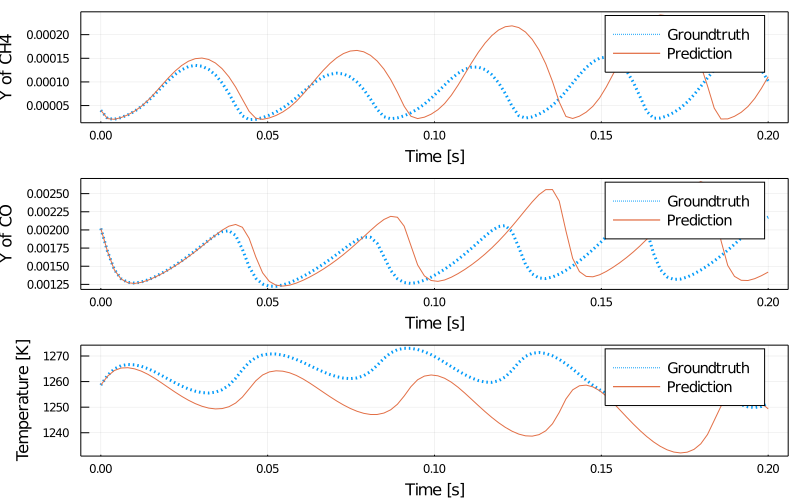

In [85]:
y_true = solve(probnn, p=p_true, solver, saveat=tsteps,
        reltol=reltol, abstol=abstol, sensealg=sensealg);
y_init = solve(probnn, p=p_init, solver, saveat=tsteps,
        reltol=reltol, abstol=abstol, sensealg=sensealg);
valid(tsteps, y_true, y_init)

In [88]:
# plot()
# plot!(re(p_true)((tsteps./tscale)')', line=:solid, label="")
# plot!(re(p_init)((tsteps./tscale)')', line=:dash, label="")

In [89]:
max_min(y) = maximum(y, dims=2) .- minimum(y, dims=2);
yscale = max_min(abs.(ct_u));

In [90]:
sensealg = ForwardDiffSensitivity();
function predict_ode(u0, p; sample = datasize)
    _prob = remake(probnn, u0=u0, p=p, tspan=[0, tsteps[sample]])
    sol = solve(_prob, solver, saveat=tsteps[1:sample], sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false)
    pred = Array(sol)
    if sol.retcode == :Success
        nothing
    else
        println("ode solver failed")
    end
    return pred
end

function loss_ode(p; abstol=1e-9, sample = datasize)
    y_pred = predict_ode(u0, p; sample)
    sc = max.(yscale, abstol);
    loss = mae(y_true./sc, y_pred./sc)
    # loss = mae(y_true, y_pred)
    return loss
end

loss_ode(p_init)

0.30297016994627246

In [91]:
losses_y_train = Vector{Float64}();
losses_y_valid = Vector{Float64}();
history_p_pred = Vector{Array{Float64}}();
push!(history_p_pred, p_init);

p_pred = deepcopy(p_init);

In [92]:
grad_max = 10^1;
function train(opt; n_epoch=100, batchsize=datasize, reltol=1e-6, abstol=1e-9)
    
    _prob = remake(probnn, u0=u0, p=p_pred, tspan=tspan)
    y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
                reltol=reltol, abstol=abstol, verbose=false))
    valid(tsteps, y_true, y_pred)

    epochs = ProgressBar(1:n_epoch);
    for epoch in epochs
        # update parameters
        global p_pred
        sample = rand(batchsize:datasize)
        grad = ForwardDiff.gradient(
                    x -> loss_ode(x; abstol=abstol, sample),
                    p_pred)
        grad_norm = norm(grad, 2)
        if grad_norm > grad_max
            grad = grad ./ grad_norm .* grad_max
        end
        update!(opt, p_pred, grad)
        
        loss_y_train = loss_ode(p_pred; abstol=abstol)
        push!(losses_y_train, loss_y_train)
        push!(history_p_pred, deepcopy(p_pred))
        
        # show results
        if epoch%5==0
            _prob = remake(probnn, u0=u0, p=p_pred, tspan=tspan)
            y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
                        reltol=reltol, abstol=abstol, verbose=false))
            valid(tsteps, y_true, y_pred)
        end
        set_description(epochs, string(@sprintf("Loss ytrain %.3e gnorm %.3e",
                    loss_y_train, grad_norm)))
    end
end

train (generic function with 1 method)

In [93]:
# opt = ADAMW(0.01, (0.9, 0.999), 1.f-6);
# train(opt; n_epoch=25, batchsize=datasize, reltol=1e-3, abstol=1e-6)

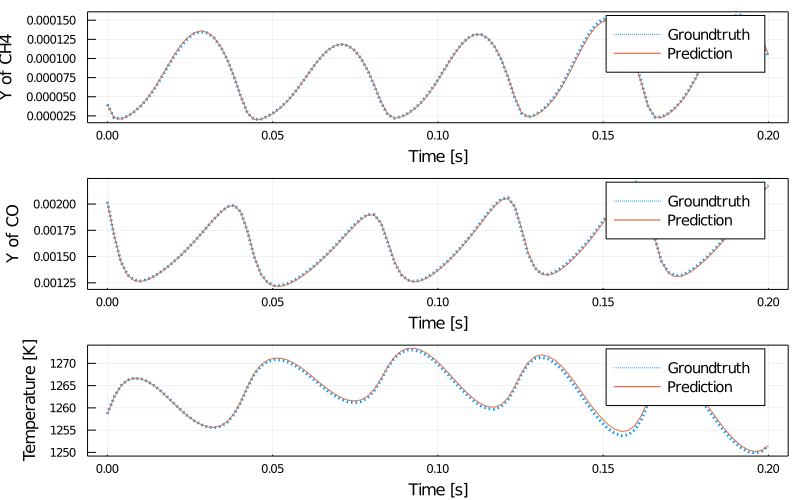

Loss ytrain 1.447e-02 gnorm 1.334e+01 100.0%┣██┫ 100/100 [09:44<00:00, 0.2 it/s]
Loss ytrain 1.447e-02 gnorm 1.334e+01 100.0%┣██┫ 100/100 [09:44<00:00, 0.2 it/s]



In [94]:
opt = ADAMW(2e-3, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=datasize, reltol=1e-6, abstol=1e-9)

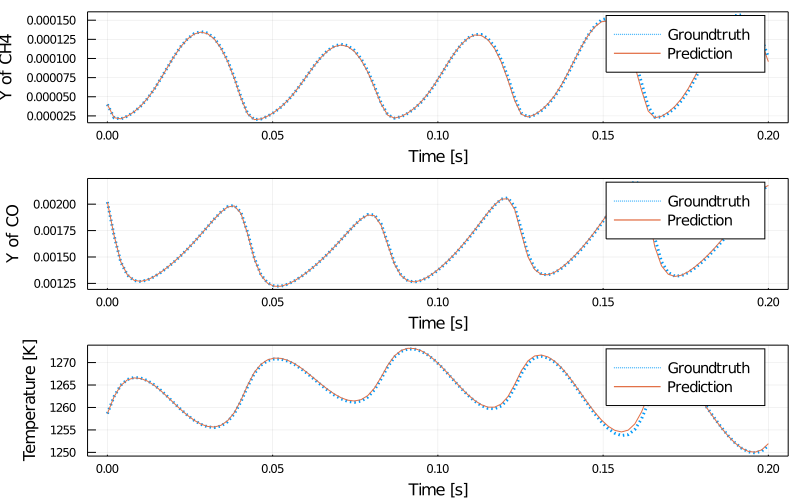

Loss ytrain 9.102e-03 gnorm 1.230e+01 100.0%┣██┫ 100/100 [08:34<00:00, 0.2 it/s]
Loss ytrain 9.102e-03 gnorm 1.230e+01 100.0%┣██┫ 100/100 [08:34<00:00, 0.2 it/s]



In [95]:
opt = ADAMW(1e-3, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=datasize, reltol=1e-9, abstol=1e-12)

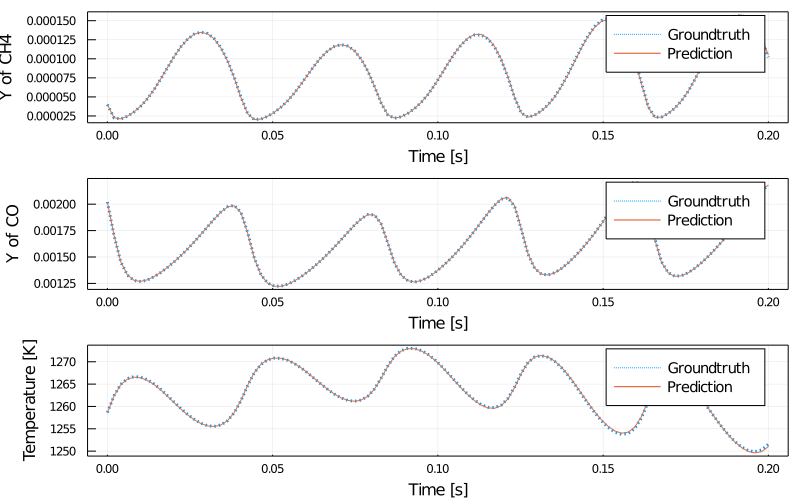

Loss ytrain 2.174e-03 gnorm 2.524e-01 100.0%┣██┫ 100/100 [08:31<00:00, 0.2 it/s]
Loss ytrain 2.174e-03 gnorm 2.524e-01 100.0%┣██┫ 100/100 [08:31<00:00, 0.2 it/s]



In [96]:
opt = ADAMW(1e-4, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=datasize, reltol=1e-9, abstol=1e-12)

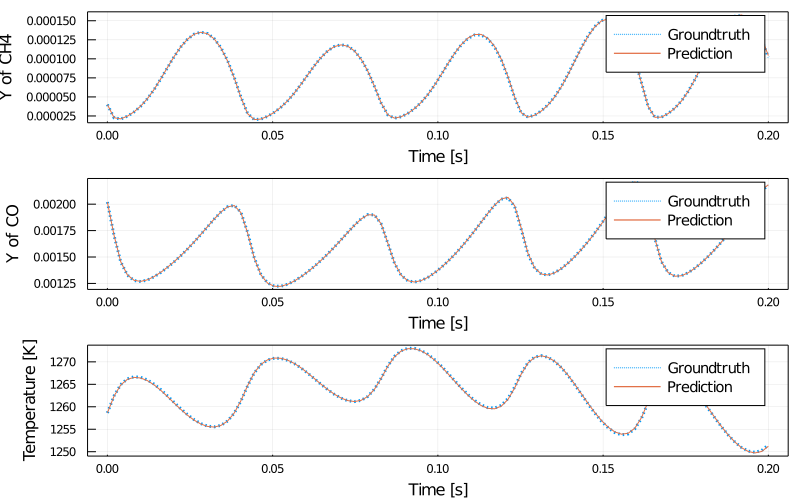

Loss ytrain 1.712e-03 gnorm 2.154e-01 100.0%┣██┫ 100/100 [08:42<00:00, 0.2 it/s]
Loss ytrain 1.712e-03 gnorm 2.154e-01 100.0%┣██┫ 100/100 [08:42<00:00, 0.2 it/s]



In [117]:
opt = ADAMW(1e-4, (0.9, 0.999), 1.f-6);
train(opt; n_epoch=100, batchsize=datasize, reltol=1e-9, abstol=1e-12)

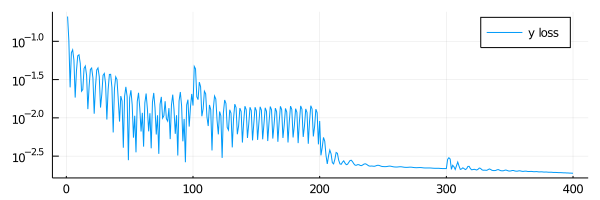

In [115]:
plot(losses_y_train, yscale=:log10, size=(600,200), label="y loss")

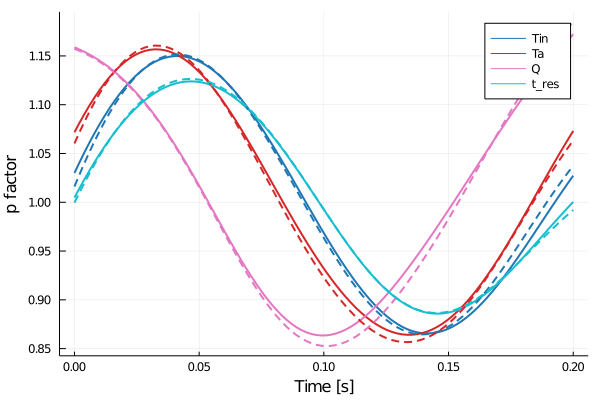

In [116]:
plot(xlabel="Time [s]", ylabel="p factor", palette=palette(:tab10, 4))
plot!(tsteps, re(p_true)((tsteps./tscale)')', line=(2,:solid), label=["Tin" "Ta" "Q" "t_res"])
plot!(tsteps, re(p_pred)((tsteps./tscale)')', line=(2,:dash), label="")

In [100]:
# # show the optimization process
# for p in history_p_pred
#     _prob = remake(probnn, u0=u0, p=p, tspan=tspan)
#     y_pred = Array(solve(_prob, solver, saveat=tsteps, sensalg=sensealg,
#                 reltol=reltol, abstol=abstol, verbose=false))
#     valid(tsteps, y_true, y_pred)
#     sleep(1e-3)
# end

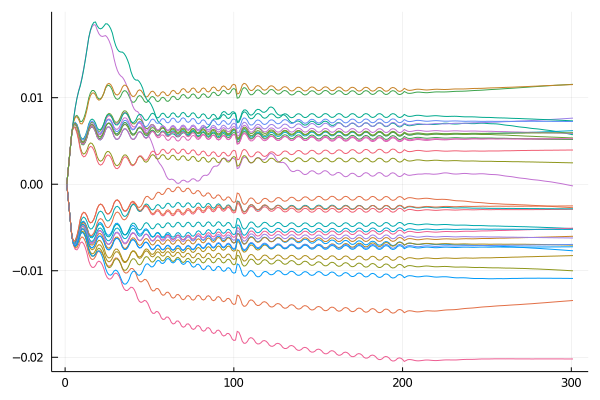

In [109]:
plot((hcat(history_p_pred...).- p_init)', label="")